In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix

In [2]:
#torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use GPU if available
data_path = 'TomatoDatasetSplitted/'   # Path of the data set

# Function to get the numbers of train, validation and test samples
def num_of_samples(folder_path, format='.jpg'):
    file_count = 0
    for root, dirs, files in os.walk(folder_path):
            for file in files:
                if file.endswith('.jpg'):
                    file_count += 1
    return file_count

train_size = num_of_samples(data_path + 'train')
val_size = num_of_samples(data_path + 'val')
test_size = num_of_samples(data_path + 'test')

transform = transforms.Compose([
        transforms.RandomRotation(20),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()])

train_set = datasets.ImageFolder(data_path + 'train', transform=transform)
val_set = datasets.ImageFolder(data_path + 'val', transform=transform)
test_set = datasets.ImageFolder(data_path + 'test', transform=transform)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1)
        self.conv4 = nn.Conv2d(64, 128, 3, 1)
        self.conv5 = nn.Conv2d(128, 256, 3, 1)
        self.fc1 = nn.Linear(6*6*256, 256)
        self.do1 = nn.Dropout(p=0.25)
        self.fc2 = nn.Linear(256, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x,2,2)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x,2,2)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x,2,2)
        
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x,2,2)
        
        x = self.conv5(x)
        x = F.relu(x)
        x = F.max_pool2d(x,2,2)
        
        # To check the shape before fully connected layer
        #print(x.shape)
        x = x.view(-1,256*6*6)
        x = self.fc1(x)
        x = self.do1(x)
        x = self.fc2(x)
        """       
        F.softmax() should not be used with nn.CrossEntropyLoss()
        nn.CrossEntropyLoss() combines nn.LogSoftmax() and nn.NLLLoss()
        Either pass raw data to nn.CrossEntropyLoss()
        or use F.log_softmax() and pass it to nn.NLLLoss()
        """
        return F.log_softmax(x, dim=1)

In [4]:
#torch.manual_seed(42)
model = Net()
if torch.cuda.is_available():
    model.cuda()

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
epoch = 100
patience = patience_limit = 10

train_loss_list = []        # List to store the average training loss of each epoch
train_correct_list = []     # List to store the number of correctly predicted training samples per epoch
val_loss_list = []          # List to store the average validation loss of each epoch
val_correct_list = []       # List to store the number of correctly predicted validation samples per epoch
best_val_loss = np.inf      # To check if the validation loss is better than the one in previous epoch, if so then store the model state
model_state = None          # Variable to store the model state
model_path = 'tomato_model.pt'  # Path to save the model

In [5]:
for i in range(epoch):
    if patience == 0:
        print(f'The validation loss has not increased in the last {patience_limit} epochs! Finishing the training...')
        break
        
    print(f'EPOCH: {i+1}')

    # Train
    train_correct = 0   # Set to 0 at the start of each epoch, will be increased for each batch
    train_loss = 0      # Set to 0 at the start of each epoch, will be increased for each batch
    model.train()       # Train mode
    for b,(x_train, y_train) in enumerate(train_loader):
        #b += 1
        x_train, y_train = x_train.to(device), y_train.to(device)
        y_pred = model(x_train)
        loss = criterion(y_pred, y_train)
        predicted = torch.max(y_pred.data, 1)[1]        # The index location of each maximum value found (argmax)
        train_correct += (predicted == y_train).sum()   # Number of the correctly predicted training samples
        train_loss += loss * y_train.size(0)            # Total training loss, will be divided by sample size to get the average loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_correct_list.append(train_correct)
    avg_train_loss = train_loss / train_size
    train_loss_list.append(avg_train_loss)
    print(f'[Train     ] Loss: {train_loss_list[i]}\tAccuracy: {train_correct_list[i] / train_size}')           

    # Validation
    val_correct = 0     # Set to 0 at the start of each epoch, will be increased for each batch
    val_loss = 0        # Set to 0 at the start of each epoch, will be increased for each batch
    model.eval()        # Validation/Test mode
    with torch.no_grad():  
        for b,(x_val, y_val) in enumerate(val_loader):
            #b += 1
            x_val, y_val = x_val.to(device), y_val.to(device)
            y_pred = model(x_val)
            loss = criterion(y_pred, y_val)
            predicted = torch.max(y_pred.data, 1)[1]    # The index location of each maximum value found (argmax)
            val_correct += (predicted == y_val).sum()   # Number of the correctly predicted validation samples
            val_loss += loss * y_val.size(0)            # Total validation loss, will be divided by sample size to get the average loss
            
    val_correct_list.append(val_correct)
    avg_val_loss = val_loss / val_size
    val_loss_list.append(avg_val_loss)
    print(f'[Validation] Loss: {val_loss_list[i]}\tAccuracy: {val_correct_list[i] / val_size}')

    # If the validation loss is better than the one in previous epoch, store the model state
    if val_loss_list[i] < best_val_loss:
        patience = patience_limit
        best_val_loss = val_loss_list[i]
        model_state = {
            'epoch': (i+1),
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss_list[i],
            }
        print('The validation loss is better, model state is stored.')

    else:
        patience -= 1
        print(f'The validation loss is not better! Patience: {patience}')
    
    print('Learning rate:', optimizer.param_groups[0]['lr'])
    scheduler.step()    # Decay the learning rate
    print('-' * 75)     # End of the epoch

# After the training, save the model with best validation loss
print('Saving the model with best validation loss...')
torch.save(model_state, model_path)

EPOCH: 1
[Train     ] Loss: 1.7282276153564453	Accuracy: 0.3554949462413788
[Validation] Loss: 1.325579047203064	Accuracy: 0.5336363911628723
The validation loss is better, model state is stored.
Learning rate: 0.001
---------------------------------------------------------------------------
EPOCH: 2
[Train     ] Loss: 1.1088465452194214	Accuracy: 0.612001359462738
[Validation] Loss: 0.9038713574409485	Accuracy: 0.6736363768577576
The validation loss is better, model state is stored.
Learning rate: 0.001
---------------------------------------------------------------------------
EPOCH: 3
[Train     ] Loss: 0.8894358277320862	Accuracy: 0.6809864640235901
[Validation] Loss: 0.7061082124710083	Accuracy: 0.7609090805053711
The validation loss is better, model state is stored.
Learning rate: 0.001
---------------------------------------------------------------------------
EPOCH: 4
[Train     ] Loss: 0.7270974516868591	Accuracy: 0.7472440004348755
[Validation] Loss: 0.6131352186203003	Accura

[Validation] Loss: 0.20350055396556854	Accuracy: 0.9381818175315857
The validation loss is not better! Patience: 4
Learning rate: 0.0008100000000000001
---------------------------------------------------------------------------
EPOCH: 29
[Train     ] Loss: 0.09274300187826157	Accuracy: 0.9679509401321411
[Validation] Loss: 0.1578553020954132	Accuracy: 0.9545454382896423
The validation loss is better, model state is stored.
Learning rate: 0.0008100000000000001
---------------------------------------------------------------------------
EPOCH: 30
[Train     ] Loss: 0.1078062355518341	Accuracy: 0.964200496673584
[Validation] Loss: 0.1628950536251068	Accuracy: 0.9609090685844421
The validation loss is not better! Patience: 9
Learning rate: 0.0008100000000000001
---------------------------------------------------------------------------
EPOCH: 31
[Train     ] Loss: 0.07812352478504181	Accuracy: 0.9698829650878906
[Validation] Loss: 0.17306320369243622	Accuracy: 0.9536363482475281
The validat

[Train     ] Loss: 0.03136853873729706	Accuracy: 0.9881804585456848
[Validation] Loss: 0.1499977707862854	Accuracy: 0.964545488357544
The validation loss is not better! Patience: 9
Learning rate: 0.00059049
---------------------------------------------------------------------------
EPOCH: 57
[Train     ] Loss: 0.04224647209048271	Accuracy: 0.9856802225112915
[Validation] Loss: 0.1677815318107605	Accuracy: 0.9627273082733154
The validation loss is not better! Patience: 8
Learning rate: 0.00059049
---------------------------------------------------------------------------
EPOCH: 58
[Train     ] Loss: 0.04203791916370392	Accuracy: 0.9861347675323486
[Validation] Loss: 0.18423406779766083	Accuracy: 0.9609090685844421
The validation loss is not better! Patience: 7
Learning rate: 0.00059049
---------------------------------------------------------------------------
EPOCH: 59
[Train     ] Loss: 0.067124143242836	Accuracy: 0.9770428538322449
[Validation] Loss: 0.1495608538389206	Accuracy: 0.96

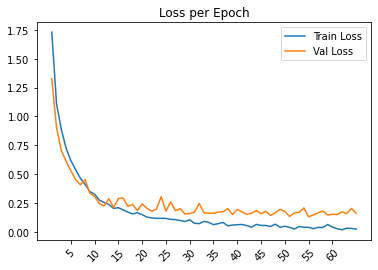

In [6]:
# Plot train and validation loss
epoch_trained = len(train_loss_list)
label_epoch_no = [i for i in range(1, epoch_trained+1)]
plt.plot(label_epoch_no, train_loss_list, label='Train Loss')
plt.plot(label_epoch_no, val_loss_list, label='Val Loss')
plt.xticks([i for i in range(5, epoch_trained, 5)], rotation=45)
plt.title('Loss per Epoch')
plt.legend()
plt.savefig('LossPlot.svg', format='svg', dpi=600, bbox_inches='tight')

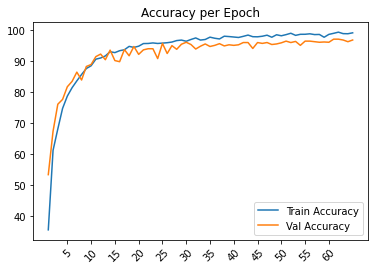

In [7]:
# Plot train and validation accuracy
plt.plot(label_epoch_no, np.divide(train_correct_list,train_size)*100, label='Train Accuracy')
plt.plot(label_epoch_no, np.divide(val_correct_list,val_size)*100, label='Val Accuracy')
plt.xticks([i for i in range(5, epoch_trained, 5)], rotation=45)
plt.title('Accuracy per Epoch')
plt.legend()
plt.savefig('AccuracyPlot.svg', format='svg', dpi=600, bbox_inches='tight')

In [8]:
# Load the trained model with best validation loss
print('Loading the model...')
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

Loading the model...


In [9]:
# Test
test_correct = 0        # Set to 0 at the start of each epoch, will be increased for each batch
test_loss = 0           # Set to 0 at the start of each epoch, will be increased for each batch

test_predictions = []   # List to store the test predictions
test_labels = []        # List to store the corresponding test labels

model.eval()            # Validation/Test mode
with torch.no_grad():  
    for b,(x_test, y_test) in enumerate(test_loader):
        #b += 1
        x_test, y_test = x_test.to(device), y_test.to(device)
        y_pred = model(x_test)
        loss = criterion(y_pred, y_test)
        predicted = torch.max(y_pred.data, 1)[1]        # The index location of each maximum value found (argmax)
        test_correct += (predicted == y_test).sum()     # Number of the correctly predicted test samples
        test_loss += loss * y_test.size(0)              # Total test loss, will be divided by sample size to get the average loss
        test_predictions.extend(predicted.cpu().view(-1))
        test_labels.extend(y_test.cpu().view(-1))

avg_test_loss = test_loss / test_size

print(f'[Test      ] Loss: {avg_test_loss}\tAccuracy: {test_correct / test_size}')

[Test      ] Loss: 0.11292929202318192	Accuracy: 0.9745454788208008


In [10]:
# Print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
# Print class names
print(test_set.class_to_idx)
# Print the confusion matrix
print(confusion_matrix(test_predictions, test_labels))

[[   0    1    2    3    4    5    6    7    8    9]]
{'BacterialSpot': 0, 'EarlyBlight': 1, 'Healthy': 2, 'LateBlight': 3, 'LeafMold': 4, 'SeptoriaLeafSpot': 5, 'SpiderMitesTwoSpottedSpiderMite': 6, 'TargetSpot': 7, 'TomatoMosaicVirus': 8, 'TomatoYellowLeafCurlVirus': 9}
[[ 107    1    1    0    0    0    0    1    0    1]
 [   1  106    0    3    0    0    0    0    0    0]
 [   0    0  108    0    0    0    0    0    0    0]
 [   1    2    0  105    0    2    0    0    0    0]
 [   0    0    0    0  108    2    0    0    0    0]
 [   1    1    0    1    2  105    0    1    0    0]
 [   0    0    0    0    0    1  107    1    0    0]
 [   0    0    0    0    0    0    2  107    0    0]
 [   0    0    0    0    0    0    1    0  110    0]
 [   0    0    1    1    0    0    0    0    0  109]]
